In [14]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
import os 
root_dir = "/content/gdrive/MyDrive/"
# project_folder = "DDP 2 Ear Biometrics"

# def create_and_set_working_directory(project_folder):
#   if os.path.isdir(root_dir + project_folder) == False:
#     os.mkdir(root_dir + project_folder)
#     print(root_dir + project_folder + ' did not exist but was created.')
#   os.chdir(root_dir + project_folder)
  
# create_and_set_working_directory(project_folder)
# ! pwd

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!pip install kymatio

In [ ]:
#This code can be used for saving the Python Notebook into a HTML file
#!jupyter nbconvert --to html May_28_Verification_on_AMI_Cropped_Triplet.ipynb

# Importing the Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models , optimizers , losses ,activations , callbacks, metrics
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Lambda, BatchNormalization, AveragePooling2D, Dropout, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

import datetime
import os
import sys
from tqdm import tqdm

from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pathlib

import scipy.io
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn import metrics as sklearn_metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# from kymatio.keras import Scattering2D

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [15]:
tf.compat.v1.enable_eager_execution()

In [16]:
# check if it's set properly
tf.executing_eagerly()

True

# Reading All the Images from the IITI Dataset

(343, 576, 3)


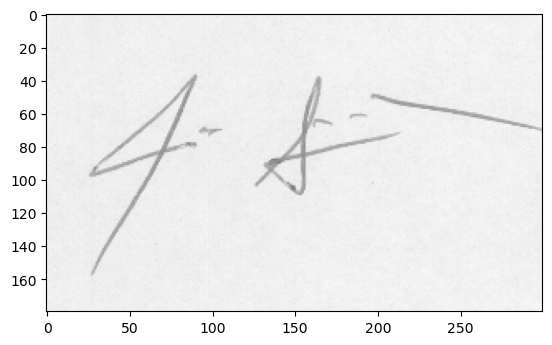

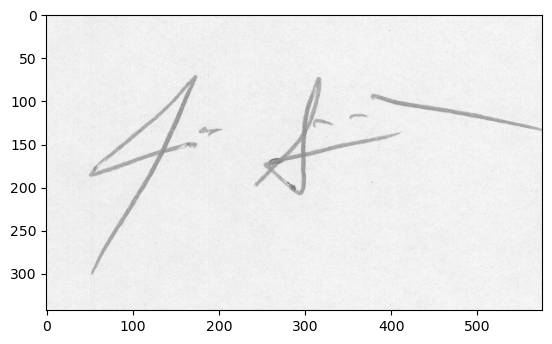

In [6]:
img = cv2.imread('/kaggle/input/sign-verification2/signatures/full_org/original_1_1.png')
print(img.shape)
img1 = cv2.resize(img,(300,180))
plt.imshow(img1)
plt.show()
plt.imshow(img)

In [2]:
folder_name = "/kaggle/input/sign-verification2/signatures/full_forg/"; extension = '.png'
min_person_index = 1; max_person_index = 40; 
min_image_index = 1; max_image_index = 24; 


missing_person_index=np.array([])
num_persons = max_person_index + 1 - min_person_index - missing_person_index.shape[0]  
num_images = max_image_index - min_image_index + 1
num_channels = 3; num_y = 180; num_x = 300;
num_z = num_channels*(max_image_index+1-min_image_index)*(max_person_index+1-min_person_index) 
forged_image = []

person_count = min_person_index;
for person_index in tqdm(range(min_person_index,max_person_index+1)):
    if person_index in missing_person_index: continue  
#     print(person_index)
    temp = []
    for image_index in range(min_image_index,max_image_index+1):
        file_path = folder_name  + 'forgeries_' + str(person_index) + '_' + str(image_index) + extension
#         print(file_path)
        
        this_image = cv2.imread(file_path)
        resized_image = cv2.resize(this_image, (num_x,num_y), interpolation = Image.BICUBIC)
#         pos_img =cv2.imread(file_path)
# #         print("Original image shape:",pos_img.shape)
#         gray = cv2.cvtColor(pos_img, cv2.COLOR_BGR2GRAY,pos_img.shape)
# #         print("Gray image shape:",gray.shape)
#         blurred = cv2.GaussianBlur(gray, (7, 7), 0)
# #         print("BLurred image shape:",blurred.shape)
#         pos_img = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 7)
# #         print("ATM image shape:",pos_img.shape)
#         pos_img =np.around((cv2.resize(pos_img, (num_x,num_y), interpolation = Image.BICUBIC)/255.0), decimals=6)
#         pos_img = np.expand_dims(pos_img, 2)
#         print("Final image shape:",pos_img.shape)
        
        temp.append(np.asarray(resized_image)/255.0)
    forged_image.append(temp)
    person_count = person_count + 1    

100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


In [3]:
folder_name = "/kaggle/input/sign-verification2/signatures/full_org/"; extension = '.png'
min_person_index = 1; max_person_index = 40; 
min_image_index = 1; max_image_index = 24; 


missing_person_index=np.array([])
num_persons = max_person_index + 1 - min_person_index - missing_person_index.shape[0]  
num_images = max_image_index - min_image_index + 1
num_channels = 3; num_y = 180; num_x = 300;
num_z = num_channels*(max_image_index+1-min_image_index)*(max_person_index+1-min_person_index) 
same_image = []

person_count = min_person_index;
for person_index in tqdm(range(min_person_index,max_person_index+1)):
    if person_index in missing_person_index: continue  
#     print(person_index)
    temp = []
    for image_index in range(min_image_index,max_image_index+1):
        file_path = folder_name  + 'original_' + str(person_index) + '_' + str(image_index) + extension
#         print(file_path)
        
        this_image = cv2.imread(file_path)
        resized_image = cv2.resize(this_image, (num_x,num_y), interpolation = Image.BICUBIC)
#         pos_img =cv2.imread(file_path)
# #         print("Original image shape:",pos_img.shape)
#         gray = cv2.cvtColor(pos_img, cv2.COLOR_BGR2GRAY,pos_img.shape)
# #         print("Gray image shape:",gray.shape)
#         blurred = cv2.GaussianBlur(gray, (7, 7), 0)
# #         print("BLurred image shape:",blurred.shape)
#         pos_img = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 7)
# #         print("ATM image shape:",pos_img.shape)
#         pos_img =np.around((cv2.resize(pos_img, (num_x,num_y), interpolation = Image.BICUBIC)/255.0), decimals=6)
#         pos_img = np.expand_dims(pos_img, 2)
#         print("Final image shape:",pos_img.shape)
        
        temp.append(np.asarray(resized_image)/255.0)
    same_image.append(temp)
    person_count = person_count + 1    

100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


In [4]:
same_img_arr = np.array(same_image)
forged_img_arr = np.array(forged_image)
print("Shape of same image array: ", same_img_arr.shape)
print("Shape of forged image array: ", forged_img_arr.shape)
del same_img_arr
del forged_img_arr

Shape of same image array:  (40, 24, 180, 300, 1)
Shape of forged image array:  (40, 24, 180, 300, 1)


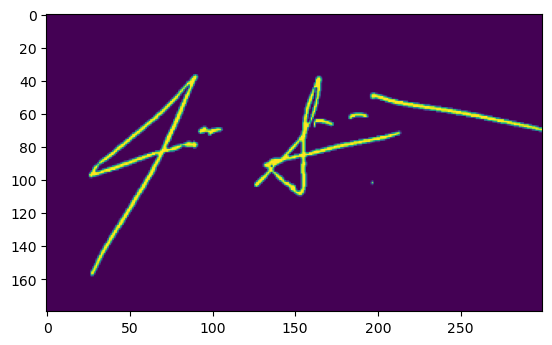

In [47]:
plt.imshow(same_image[0][0])

# Functions for Generating the Pairs IDs Required in Siamese Trainings

In [4]:
def make_triplets_ids(num_person_start, num_person_stop, num_image_start, num_image_stop,neg_image_start,neg_image_stop):
    list_person_anchor = []
    list_image_anchor = []
    list_image_positive = []
    list_image_negative = []

    for person in tqdm(range(num_person_start, num_person_stop + 1)):
        for anchor_image in range(num_image_start, num_image_stop + 1):
            for positive_image in range(anchor_image + 1, num_image_stop + 1):
                for negative_image in range(neg_image_start, neg_image_stop + 1):

                            list_person_anchor.append(person)
                            list_image_anchor.append(anchor_image)
                            list_image_positive.append(positive_image)
                            list_image_negative.append(negative_image)

    list_person_anchor = np.expand_dims(np.array(list_person_anchor), 0)
    list_image_anchor = np.expand_dims(np.array(list_image_anchor), 0)
    list_image_positive = np.expand_dims(np.array(list_image_positive), 0)
    list_image_negative = np.expand_dims(np.array(list_image_negative), 0)

    triplets_ids = np.concatenate((list_person_anchor,list_image_anchor, list_image_positive, list_image_negative), 0)
    print("Shape of ids", triplets_ids.shape)
    return triplets_ids

def make_genuine_pairs_ids(num_person_start,num_person_stop,num_image_start,num_image_stop):
    list_person1 = []; list_person2 = []; list_image1 = []; list_image2 = [];                 
    for person in tqdm(range(num_person_start,num_person_stop+1)):
        for image1 in range(num_image_start,num_image_stop+1):
            for image2 in range(image1+1,num_image_stop+1):
                list_person1.append(person); list_person2.append(person); 
                list_image1.append(image1)
                list_image2.append(image2)

    list_person1 = np.expand_dims(np.array(list_person1),0);
    list_person2 = np.expand_dims(np.array(list_person2),0);
    list_image1 = np.expand_dims(np.array(list_image1),0); 
    list_image2 = np.expand_dims(np.array(list_image2),0)          
    
    genuine_ids = np.concatenate((list_person1,list_person2,list_image1,list_image2),0)
    return genuine_ids

def make_imposter_pairs_ids(num_person_start,num_person_stop,num_image_start,num_image_stop,neg_image_start,neg_image_stop):
    list_person1 = []; list_person2 = []; list_image1 = []; list_image2 = [];                 
    for person in tqdm(range(num_person_start,num_person_stop+1)):
        for image1 in range(num_image_start,num_image_stop+1):
            for image2 in range(neg_image_start,neg_image_stop+1):
                list_person1.append(person); list_person2.append(person); 
                list_image1.append(image1)
                list_image2.append(image2)

    list_person1 = np.expand_dims(np.array(list_person1),0);
    list_person2 = np.expand_dims(np.array(list_person2),0);
    list_image1 = np.expand_dims(np.array(list_image1),0); 
    list_image2 = np.expand_dims(np.array(list_image2),0)          
    
    imposter_ids = np.concatenate((list_person1,list_person2,list_image1,list_image2),0)
    return imposter_ids    

def plot_2_images_side_by_side(img1, img2, name):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(img1)
    ax[0].set_title("Image 1")
    ax[1].imshow(img2)
    ax[1].set_title("Image 2")
    fig.suptitle(name, fontsize=14, fontweight='bold')
    plt.show() 

def plot_3_images_side_by_side(img1, img2, img3, name):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
    ax[0].imshow(img1)
    ax[0].set_title("Anchor")
    ax[1].imshow(img2)
    ax[1].set_title("Positive")
    ax[2].imshow(img3)
    ax[2].set_title("Negative")    
    fig.suptitle(name, fontsize=14, fontweight='bold')
    plt.show()      

In [7]:
# Making triplets
all_triplets_ids = make_triplets_ids(1,40,1,24,1,24)
all_triplets_ids = shuffle(all_triplets_ids.transpose(),random_state=20).transpose()
num_triplets_used = 100001; all_triplets_ids = all_triplets_ids[:,:num_triplets_used]  

percentage_train_data = 0.78;
num_triplets_in_train = int(np.floor(percentage_train_data*num_triplets_used))
train_triplets_ids = all_triplets_ids[:,:num_triplets_in_train]
val_triplets_ids = all_triplets_ids[:,num_triplets_in_train:]

print("\n")
print("The shape of array with triplet IDs: ",all_triplets_ids.shape)
print("The shape of array with train triplet IDs: ",train_triplets_ids.shape)
print("The shape of array with validation triplet IDs: ",val_triplets_ids.shape)

100%|██████████| 40/40 [00:00<00:00, 425.73it/s]


Shape of ids (4, 264960)


The shape of array with triplet IDs:  (4, 100001)
The shape of array with train triplet IDs:  (4, 78000)
The shape of array with validation triplet IDs:  (4, 22001)


# Code for DataLoader

In [5]:
class SiameseDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, pair_ids_labels, all_read_images,batch_size=128):
        self.pair_ids_labels = pair_ids_labels
        self.all_read_images = all_read_images
        self.batch_size = batch_size
        
    def __len__(self):
        return (self.pair_ids_labels.shape[1]//self.batch_size) + 1
    
    def __getitem__(self, idx):
        image_pairs = []; pairs_labels = [];
        
        if idx < (self.pair_ids_labels.shape[1]//self.batch_size): 
            for i in range(idx*self.batch_size,(idx+1)*self.batch_size):
                first_image = self.all_read_images[int(self.pair_ids_labels[0,i]-1),int(self.pair_ids_labels[2,i]-1)] 
                second_image = self.all_read_images[int(self.pair_ids_labels[1,i]-1),int(self.pair_ids_labels[3,i]-1)]   
                pairs_this = np.concatenate((np.expand_dims(first_image,axis=0),np.expand_dims(second_image,axis=0)),axis=0) 
                image_pairs.append(pairs_this); pairs_labels.append(self.pair_ids_labels[4,i]);
        
        else: 
            for i in range(idx*self.batch_size,self.pair_ids_labels.shape[1]):
                first_image = self.all_read_images[int(self.pair_ids_labels[0,i]-1),int(self.pair_ids_labels[2,i]-1)] 
                second_image = self.all_read_images[int(self.pair_ids_labels[1,i]-1),int(self.pair_ids_labels[3,i]-1)]   
                pairs_this = np.concatenate((np.expand_dims(first_image,axis=0),np.expand_dims(second_image,axis=0)),axis=0) 
                image_pairs.append(pairs_this); pairs_labels.append(self.pair_ids_labels[4,i]);
        
        image_pairs = np.array(image_pairs); #print(image_pairs.shape) 
        return [image_pairs[:,0],image_pairs[:,1]], np.array(pairs_labels)    

class SiameseTripletDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, triplet_ids, same_image,diff_image,batch_size=128):
        self.triplet_ids = triplet_ids.astype('int')
        self.same_image = same_image
        self.diff_image = diff_image
        self.batch_size = batch_size
        
    def __len__(self):
        return (self.triplet_ids.shape[1]//self.batch_size) + 1
    
    def __getitem__(self, idx):
        image_triplets = []; 
        
#         print("idx=",idx,(self.triplet_ids.shape[1]//self.batch_size))
        if idx < (self.triplet_ids.shape[1]//self.batch_size): 
            for i in range(idx*self.batch_size,(idx+1)*self.batch_size):
                anchor_image = self.same_image[self.triplet_ids[0,i]-1][self.triplet_ids[1,i]-1]
                positive_image = self.same_image[self.triplet_ids[0,i]-1][self.triplet_ids[2,i]-1]
                negative_image = self.diff_image[self.triplet_ids[0,i]-1][self.triplet_ids[3,i]-1]
                
                triplet_this = np.concatenate((np.expand_dims(anchor_image,axis=0),np.expand_dims(positive_image,axis=0),np.expand_dims(negative_image,axis=0)),axis=0) 
                image_triplets.append(triplet_this); 

        else: 
            for i in range(idx*self.batch_size,self.triplet_ids.shape[1]):
                anchor_image = self.same_image[self.triplet_ids[0,i]-1][self.triplet_ids[1,i]-1]
                positive_image = self.same_image[self.triplet_ids[0,i]-1][self.triplet_ids[2,i]-1]
                negative_image = self.diff_image[self.triplet_ids[0,i]-1][self.triplet_ids[3,i]-1]
                
                triplet_this = np.concatenate((np.expand_dims(anchor_image,axis=0),np.expand_dims(positive_image,axis=0),np.expand_dims(negative_image,axis=0)),axis=0) 
                image_triplets.append(triplet_this); 
        
        image_triplets = np.array(image_triplets);
#         print("Dataset with ",idx,image_triplets.shape,image_triplets[0].shape,image_triplets[:,0].shape,image_triplets[:,1].shape,image_triplets[:,2].shape)
        return ((image_triplets[:,0],image_triplets[:,1],image_triplets[:,2]), np.ones(self.batch_size)) #it returns the three images, and a vector of ones as dummy labels (not used)

In [9]:
my_batch_size=64
train_loader = SiameseTripletDataGenerator(train_triplets_ids,same_image,forged_image,batch_size=my_batch_size)
val_loader = SiameseTripletDataGenerator(val_triplets_ids,same_image,forged_image,batch_size=my_batch_size)

In [21]:
train_triplets_ids[0,:5],train_triplets_ids[1,:5],train_triplets_ids[2,:5],train_triplets_ids[3,:5]

(array([ 5, 33, 22,  5, 24]),
 array([12, 13,  2,  7,  6]),
 array([13, 24,  4, 24, 18]),
 array([12, 13,  7, 15, 22]))

idx= 0 1250
Dataset with  0 (64, 3, 180, 300, 1) (3, 180, 300, 1) (64, 180, 300, 1) (64, 180, 300, 1) (64, 180, 300, 1)


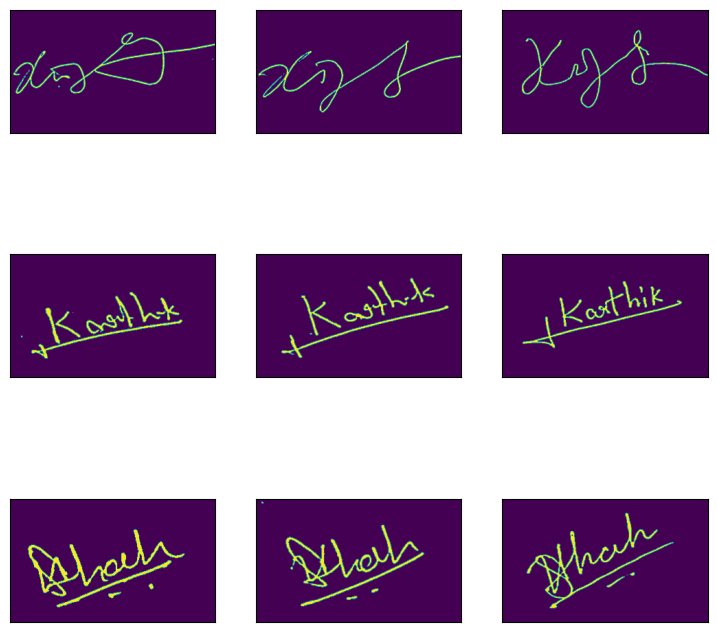

In [22]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
#     print(anchor.shape, positive.shape,negative.shape)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

visualize(*list(train_loader[0])[0])

# Defining Network for Learning Embeddings 

In [6]:
# def triplet_loss(y_true, y_pred, margin=10):
#     anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
#     # Compute the Euclidean distances
#     pos_dist = K.sum(K.square(anchor - positive), axis=-1)
#     neg_dist = K.sum(K.square(anchor - negative), axis=-1)
#     basic_loss = pos_dist - neg_dist + margin
#     loss = K.maximum(basic_loss, 0.0)
    
#     return loss


# Define Siamese network architecture
def build_siamese_model_vansh(input_shape):
    # Define input layer
    inputs = Input(shape=input_shape)

    # Define 2D Scattering transform layer
    scattering = Scattering2D(J=3)(inputs)
    # Plot Scattering coefficients
#     print("Scattering",inputs.shape)
    
    model = (Conv2D(4, (3, 3),strides=1,padding='same', activation='relu', input_shape=input_shape))(scattering)
    model = (BatchNormalization())(model)
    model = (Conv2D(8, (3, 3),strides=1,padding='same', activation='relu', input_shape=input_shape))(model)
    model = (BatchNormalization())(model)
    model = (Conv2D(8, (3, 3),strides=1,padding='same', activation='relu', input_shape=input_shape))(model)
    model = (BatchNormalization())(model)
    model = (AveragePooling2D(pool_size=(2, 2), strides=2))(model)
    model = (Flatten())(model)
    model = (Dense(512))(model)
    model = tf.keras.layers.Dropout(0.2)(model) 
    X = (Dense(128))(model)
#     outputs = (Dense(16))(model)
#     X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(model)

    # Bui4ld model
    model = Model(inputs=inputs, outputs=X)

    return model

drop_out_rate = 0.2; activation_name = 'relu'; init_filt_num = 16;

def create_base_network(input_shape):
    # Create a base network for the Siamese model
    inputs = Input(shape=input_shape)
#     print("Scattering",inputs.shape)
#     scattering = Scattering2D(J=2)(inputs)

    x = Conv2D(filters=init_filt_num, kernel_size=(3,3), padding='same', strides=(1,1), activation=activation_name)(inputs)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(2, 2),strides=2)(x)
    x = Conv2D(filters=init_filt_num, kernel_size=(3,3), padding='same', strides=(1,1), activation=activation_name)(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(2, 2),strides=2)(x)
    x = Dropout(drop_out_rate)(x)

    x = Conv2D(filters=2*init_filt_num, kernel_size=(3,3), padding='same', strides=(1,1), activation=activation_name)(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(2, 2),strides=2)(x)
    x = Conv2D(filters=2*init_filt_num, kernel_size=(3,3), padding='same', strides=(1,1), activation=activation_name)(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(2, 2),strides=2)(x)
    x = Dropout(drop_out_rate)(x)

    x = Conv2D(filters=4*init_filt_num, kernel_size=(3,3), padding='same', strides=(1,1), activation=activation_name)(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(2, 2),strides=2)(x)
    x = Conv2D(filters=4*init_filt_num, kernel_size=(3,3), padding='same', strides=(1,1), activation=activation_name)(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(2, 2),strides=2)(x)
    x = Dropout(drop_out_rate)(x)    

    x = Flatten()(x)
    x = Dense(512, activation=activation_name)(x)
    x = Dropout(drop_out_rate)(x)
    x = Dense(128)(x)

    model = Model(inputs, x)
    return model  

def create_siamese_model(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    input_c = Input(shape=input_shape)

    base_network = create_base_network(input_shape)

    output_a = base_network(input_a)
    output_b = base_network(input_b)
    output_c = base_network(input_c)
    
    output = Lambda(lambda x: [x[0], x[1], x[2]])([output_a, output_b, output_c])
    model = Model(inputs=[input_a, input_b, input_c], outputs=output)

    #model = Model(inputs=[input_a, input_b, input_c], outputs=[output_a, output_b, output_c], name = "Siamese_Network")
    return model, base_network

def plot_loss(history):
    plt.plot(history.history['loss'], '*-', label='train')
    plt.plot(history.history['val_loss'], 'o-', label='validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(loc="upper right")
    plt.show()    

In [7]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


In [75]:
# same_image = np.array(same_image)
len(same_image[1][1][1][1])

1

In [8]:
input_shape=(180, 300,3)
embedding=create_base_network(input_shape)
anchor_input = layers.Input(name="anchor", shape=input_shape)
positive_input = layers.Input(name="positive", shape=input_shape)
negative_input = layers.Input(name="negative", shape=input_shape)
# scattering_anchor = Scattering2D(J=2)(anchor_input)
# scattering_positive = Scattering2D(J=2)(positive_input)
# scattering_negative = Scattering2D(J=2)(negative_input)
# print(scattering_anchor.shape[1:],scattering_positive.shape,scattering_negative.shape)
# embedding=build_siamese_model_vansh(scattering_anchor.shape[1:])

distances = DistanceLayer()(
    embedding((anchor_input)),
    embedding((positive_input)),
    embedding((negative_input)),
)

siamese_network = Model(
    
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
#     inputs=[scattering_anchor, scattering_positive, scattering_negative], outputs=distances
)

In [9]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
#         print("call function")
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        
#         print("Train step")
        
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
#         print("Compute function",len(data),len(data[0]),data[0][0].shape)
        ((anchor_images, positive_images, negative_images), _) = data  # Unpack the data from the DataLoader
        ap_distance, an_distance = self.siamese_network((anchor_images, positive_images, negative_images))
#         print(type(anchor_images))
#         scat = Scattering2D(J=2)
#         S = scat((anchor_images).numpy())
#         Sn = scat((negative_images).numpy())
#         Sp = scat((positive_images).numpy())
#         print((anchor_images.shape, positive_images.shape, negative_images.shape))
#         ap_distance, an_distance = self.siamese_network((S, Sp, Sn))

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    
    def save_model(self,file_path):
        self.siamese_network.save(file_path)
    
    def load_model(self,path):
        custom_objects = {"DistanceLayer": DistanceLayer}
        self.siamese_network = tf.keras.models.load_model(path, custom_objects=custom_objects)  
        return self.siamese_network
    
    def summary(self):
        return self.siamese_network.summary()

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

# Training of the CNN Model

In [10]:
siamese_model = SiameseModel(siamese_network)
learning_rate = 5e-4; beta_1 = 0.9; beta_2 = 0.999; epsilon = 1e-7
optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
siamese_model.compile(optimizer=optimizer)
print("Parameters in siamese network is-------------------------------- \n")
siamese_model.summary()

Parameters in siamese network is-------------------------------- 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 180, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 180, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 180, 300, 3  0           []                               
                         

In [23]:
tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

In [24]:
history = siamese_model.fit((train_loader), epochs=5, validation_data=val_loader)


plt.figure(figsize=(10,5))
plot_loss(history)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1219/1219 [==============================] - 469s 383ms/step - loss: 0.0044 - val_loss: 3.3224e-05
Epoch 2/5
1219/1219 [==============================] - 527s 433ms/step - loss: 3.5088e-05 - val_loss: 0.0000e+00


KeyboardInterrupt: 

In [ ]:
# tf.saved_model.save(siamese_model, '/kaggle/working/May_29_Verification_on_AMI_Cropped_Triplet_Anmol')

In [28]:
#  Saving model
siamese_model.save_model('/kaggle/working/Signature_Sign-Verif2_Triplet_Anmol_ArchismanNetwork_No_Pre_11June.h5')

# Checking the Embeddings Generated For Train Set

In [11]:
# FOr loading model
siamese_model_load = SiameseModel(siamese_network)
siamese_model_loaded = siamese_model_load.load_model('/kaggle/input/ver2-model/Signature_Sign-Verif2_Triplet_Anmol_ArchismanNetwork_No_Pre_11June.h5')

In [36]:
# Functions used in verification performace ---------------------------------------------------------------------------------------------
def generate_roc_pr_curves(distances, labels):
    # Compute false positive rate, true positive rate, and ROC AUC
    roc_fpr, roc_tpr, roc_th = roc_curve(labels, -distances, pos_label=1); 
    roc_auc = auc(roc_fpr, roc_tpr)

    # Compute precision, recall, and PR AUC
    pr_precision, pr_recall, _ = precision_recall_curve(labels, -distances, pos_label=1)
    pr_auc = auc(pr_recall, pr_precision)

    eer = brentq(lambda x : 1. - x - interp1d(roc_fpr,roc_tpr)(x), 0.0, 1.0)
    diffs = np.abs(roc_fpr - eer); min_diff_index = np.argmin(diffs);
    optimal_threshold = roc_th[min_diff_index]
    if eer == 0:
        diffs = np.abs(roc_fpr - eer); min_diff_index = np.arange(diffs.shape[0])[diffs==0][-1];
        optimal_threshold = roc_th[min_diff_index]        
    #print(diffs)
    #plt.plot(diffs); plt.scatter(min_diff_index,diffs[min_diff_index],marker='o',s=50); plt.show();
    return roc_fpr, roc_tpr, roc_auc, pr_recall, pr_precision, pr_auc, eer, optimal_threshold

def plotting_verification_curves(roc_fpr,roc_tpr,roc_auc,pr_recall,pr_precision,pr_auc,eer,train_test_title,dec_points=6):
    plt.subplot(1,2,1)
    plt.plot(roc_fpr,roc_tpr,color='magenta',linewidth=2)
    plt.plot(roc_fpr,1-roc_fpr,'k--',linewidth=0.5)
    plt.title(train_test_title+" ROC Curve",fontsize=20)
    plt.xlabel("FPR", fontsize=15); plt.ylabel("TPR", fontsize=15);
    plt.xlim([-0.1,1.1]); plt.ylim([-0.1,1.1]); 
    plt.grid(color='cyan', linestyle='--', linewidth=0.5)
    plt.scatter(eer,1-eer,marker='o',s=50)
    plt.legend(["AUROC = " + str(np.around(roc_auc,dec_points)),"y=1-x", "EER = " + str(np.around(100*eer,dec_points-2)) + "%"], loc="center right");

    plt.subplot(1,2,2)
    plt.plot(pr_recall,pr_precision,color='lime',linewidth=2)
    plt.title(train_test_title+" PR Curve",fontsize=20)
    plt.xlabel("Recall", fontsize=15); plt.ylabel("Precision", fontsize=15);
    plt.xlim([-0.1,1.1]); plt.ylim([-0.1,1.1]); 
    plt.grid(color='cyan', linestyle='--', linewidth=0.5)
    plt.legend(["AUPR = " + str(np.around(pr_auc,4))], loc="lower left");

def printing_verification_metrics(train_test_title, roc_auc, pr_auc, eer, dec_points = 6):
    print("On the " + train_test_title + " set:\n")
    print("The AUROC value is: ", np.round(roc_auc,dec_points))
    print("The AUPR value is: ", np.round(pr_auc,dec_points))
    print("The EER is: ", np.round(100*eer,dec_points))    

def plotting_histograms(calc_dist,GT_labels,optimal_threshold,eer,title,num_bins=50,my_alpha=0.3,density=True,dec_points=6):
    
    plt.title(title,fontsize=20)
    plt.xlabel("Eucledian distances between embeddings",fontsize=15)
    if density: plt.ylabel("Density",fontsize=15) 
    else: plt.ylabel("Counts",fontsize=15) 
    plt.hist(calc_dist[GT_labels==1], bins=num_bins, alpha=my_alpha, color='green', label='Genuine Pairs',density=density)
    plt.hist(calc_dist[GT_labels==0], bins=num_bins, alpha=my_alpha, color='red', label='Imposter Pairs',density=density)
    plt.axvline(x=optimal_threshold,color='b',linestyle='--',label="Optimal Threshold")
    plt.annotate("Opt. Th. = " + str(np.around(optimal_threshold,dec_points)) + "; EER = " + str(str(np.around(100*eer,dec_points-2)) + "%"),
                 xy=(optimal_threshold, plt.ylim()[1]), xytext=(5, -10), textcoords='offset points', color='b', va='top', ha='left', rotation='vertical')
    #plt.text(optimal_threshold, plt.ylim()[1] * 0.5, "Opt. Th. = " + str(np.around(optimal_threshold,3)), color='gold', ha='center')
    plt.legend(loc="upper left"); plt.grid(color='cyan', linestyle='--', linewidth=0.5)

def eucledian_dist(vec_1,vec_2):
    return np.linalg.norm(vec_1-vec_2, axis=1)

def normalized_eucledian_dist(vec_1,vec_2):
    normalized_vec_1 = vec_1/np.linalg.norm(vec_1, axis=1, keepdims=True)
    normalized_vec_2 = vec_2/np.linalg.norm(vec_2, axis=1, keepdims=True)
    return np.linalg.norm(normalized_vec_1-normalized_vec_2, axis=1)

def cosine_dist(vec_1, vec_2):
    dot_product = np.sum(np.multiply(vec_1,vec_2), axis=1)
    magnitude_1 = np.linalg.norm(vec_1, axis=1)
    magnitude_2 = np.linalg.norm(vec_2, axis=1)
    return 1 - (dot_product/(magnitude_1*magnitude_2))

def calculate_pair_distances(base_network,same_pair,diff_pair,genuine_ids,imposter_ids,b=128,dist_method="Eucledian"):

    num_batches_same = genuine_ids.shape[1]//b; 
    if np.mod(genuine_ids.shape[1],b) !=0: num_batches_same = num_batches_same + 1 
    
    num_batches_diff = imposter_ids.shape[1]//b; 
    if np.mod(imposter_ids.shape[1],b) !=0: num_batches_diff = num_batches_diff + 1 
    
    calc_dist = np.array([]);
    GT_labels = [];  
    if dist_method=="Eucledian":  
        for i in tqdm(range(num_batches_same)):
            calc_dist = np.concatenate((calc_dist,(eucledian_dist(base_network.predict(same_pair[genuine_ids[0,b*i:b*(i+1)].astype('int')-1,genuine_ids[2,b*i:b*(i+1)].astype('int')-1],verbose=0),
                        base_network.predict(same_pair[genuine_ids[1,b*i:b*(i+1)].astype('int')-1,genuine_ids[3,b*i:b*(i+1)].astype('int')-1],verbose=0)))))
              
        for i in tqdm(range(num_batches_diff)):
            calc_dist = np.concatenate((calc_dist,(eucledian_dist(base_network.predict(same_pair[imposter_ids[0,b*i:b*(i+1)].astype('int')-1,imposter_ids[2,b*i:b*(i+1)].astype('int')-1],verbose=0),
                        base_network.predict(diff_pair[imposter_ids[1,b*i:b*(i+1)].astype('int')-1,imposter_ids[3,b*i:b*(i+1)].astype('int')-1],verbose=0)))))
    if dist_method=="Nomalized Eucledian":  
        for i in tqdm(range(num_batches)):
            calc_dist = np.concatenate((calc_dist,(normalized_eucledian_dist(base_network.predict(all_read_images[pair_ids_labels[0,b*i:b*(i+1)].astype('int')-1,pair_ids_labels[2,b*i:b*(i+1)].astype('int')-1],verbose=0),
                        base_network.predict(all_read_images[pair_ids_labels[1,b*i:b*(i+1)].astype('int')-1,pair_ids_labels[3,b*i:b*(i+1)].astype('int')-1],verbose=0)))))
    
    if dist_method=="Cosine":  
        for i in tqdm(range(num_batches)):
            calc_dist = np.concatenate((calc_dist,(cosine_dist(base_network.predict(all_read_images[pair_ids_labels[0,b*i:b*(i+1)].astype('int')-1,pair_ids_labels[2,b*i:b*(i+1)].astype('int')-1],verbose=0),
                        base_network.predict(all_read_images[pair_ids_labels[1,b*i:b*(i+1)].astype('int')-1,pair_ids_labels[3,b*i:b*(i+1)].astype('int')-1],verbose=0)))))
         
    return calc_dist, GT_labels     

In [13]:
# If loading model and using then run this
embedding = (siamese_model_loaded).layers[3]

In [14]:
num_persons_for_training = 40
genuine_ids = make_genuine_pairs_ids(1,num_persons_for_training,1,24)
imposter_ids = make_imposter_pairs_ids(1,num_persons_for_training,1,24,1,24)

labels = np.expand_dims(np.concatenate((np.ones(genuine_ids.shape[1]),np.zeros(imposter_ids.shape[1])),0),0)
all_pair_ids = np.concatenate((genuine_ids,imposter_ids),1)
train_pair_ids_labels = np.concatenate((all_pair_ids,labels),0) 
print("Lables: ", labels.shape)

print("\n")
print("The shape of array with genuine IDs: ",genuine_ids.shape)
print("The shape of array with imposter IDs: ",imposter_ids.shape)
# kknhjkk
same_img_arr = np.array(same_image)
forged_img_arr = np.array(forged_image)

print("\n")
print("The shape of array with same image: ",same_img_arr.shape)
print("The shape of array with forged image: ",forged_img_arr.shape)

train_dist, train_labels = calculate_pair_distances(embedding,same_img_arr,forged_img_arr,genuine_ids,imposter_ids,64,dist_method="Eucledian")

100%|██████████| 40/40 [00:00<00:00, 5094.66it/s]


Lables:  (1, 34080)


The shape of array with genuine IDs:  (4, 11040)
The shape of array with imposter IDs:  (4, 23040)


The shape of array with same image:  (40, 24, 180, 300, 3)
The shape of array with forged image:  (40, 24, 180, 300, 3)


100%|██████████| 360/360 [02:31<00:00,  2.37it/s]


In [41]:
print(f"number of same(1): {np.count_nonzero(labels[0])}" )
print(f"number of diff(0): {labels[0].size - np.count_nonzero(labels[0])}")

number of same(1): 11040
number of diff(0): 23040


In [42]:
train_dist_temp = train_dist<2.674
print(f"number of same(1): {np.count_nonzero(train_dist_temp)}" )
print(f"number of diff(0): {train_dist_temp.size - np.count_nonzero(train_dist_temp)}")
del train_dist_temp

number of same(1): 11476
number of diff(0): 22604


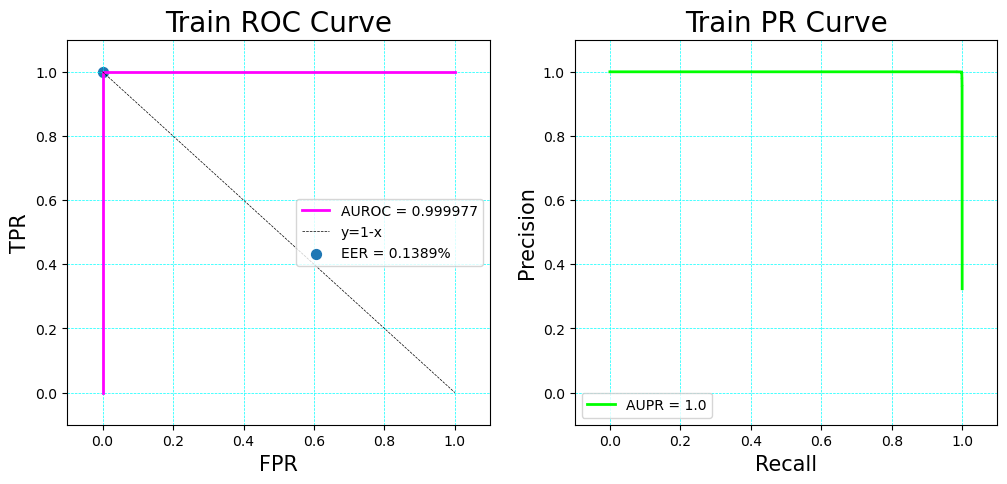

On the Train set:

The AUROC value is:  1.0
The AUPR value is:  1.0
The EER is:  0.1389


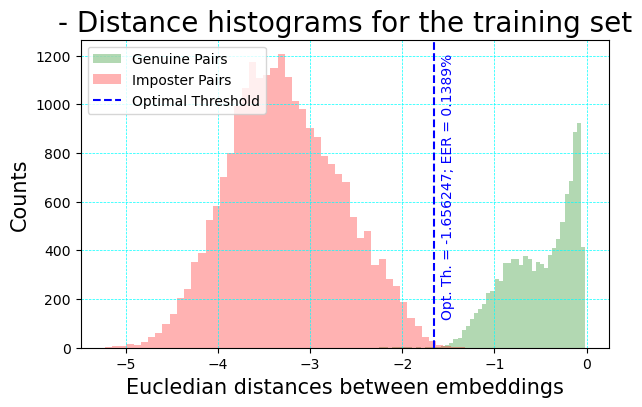

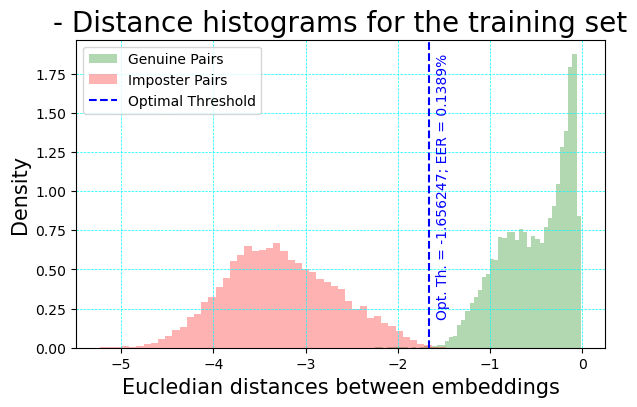

In [15]:
# train_dist, train_labels = calculate_pair_distances(base_network,all_read_images_train,train_pair_ids_labels,128,dist_method="Eucledian")
# val_dist, val_labels = calculate_pair_distances(base_network,all_read_images_train,val_pair_ids_labels,128,dist_method="Eucledian")

# Result on the Training Dataset
roc_fpr, roc_tpr, roc_auc, pr_recall, pr_precision, pr_auc, eer_train, optimal_threshold_train = generate_roc_pr_curves(train_dist, labels[0])
plt.figure(figsize=(12,5))
plotting_verification_curves(roc_fpr, roc_tpr, roc_auc, pr_recall, pr_precision, pr_auc, eer_train,"Train")
#plt.savefig("F64_train_ver_plots_AMI.pdf", format="pdf", bbox_inches="tight")
plt.show()
printing_verification_metrics("Train",roc_auc, pr_auc, eer_train, dec_points = 4)

# # Result on the Validation Dataset
# roc_fpr, roc_tpr, roc_auc, pr_recall, pr_precision, pr_auc, eer_val, optimal_threshold_val = generate_roc_pr_curves(val_dist, val_labels)
# plt.figure(figsize=(12,5))
# plotting_verification_curves(roc_fpr, roc_tpr, roc_auc, pr_recall, pr_precision, pr_auc, eer_val,"Validation")
# #plt.savefig("F64_val_ver_plots_AMI.pdf", format="pdf", bbox_inches="tight")
# plt.show()
# printing_verification_metrics("Validation",roc_auc, pr_auc, eer_val, dec_points = 4)

# Displaying the histograms
plt.figure(figsize=(15,4));
plt.subplot(1,2,1); plotting_histograms(-train_dist,labels[0],optimal_threshold_train,eer_train,"- Distance histograms for the training set",num_bins=50,my_alpha=0.3,density=False);
# plt.subplot(1,2,2); plotting_histograms(-val_dist,val_labels,optimal_threshold_val,eer_val,"- Distance histograms for the validation set",num_bins=50,my_alpha=0.3,density=False);
plt.show()

plt.figure(figsize=(15,4));
plt.subplot(1,2,1); plotting_histograms(-train_dist,labels[0],optimal_threshold_train,eer_train,"- Distance histograms for the training set",num_bins=50,my_alpha=0.3,density=True);
# plt.subplot(1,2,2); plotting_histograms(-val_dist,val_labels,optimal_threshold_val,eer_val,"- Distance histograms for the validation set",num_bins=50,my_alpha=0.3,density=True);
#plt.savefig("F64_hists_train_val_AMI.pdf", format="pdf", bbox_inches="tight")
plt.show()



# # Result on the Training Dataset
# roc_fpr, roc_tpr, roc_auc, pr_recall, pr_precision, pr_auc, eer, optimal_threshold_train = generate_roc_pr_curves(train_dist, train_labels)
# plt.figure(figsize=(12,5))
# plotting_verification_curves(roc_fpr,roc_tpr,pr_recall,pr_precision,"Train")
# plt.show()
# printing_verification_metrics("Train", dec_points = 4)

# # Displaying the histograms
# plt.figure(figsize=(8,5));
# plotting_histograms(-train_dist,train_labels,optimal_threshold_train,"- Distance histograms for the training set",num_bins=50,my_alpha=0.3,density=False);
# plt.show()

# plt.figure(figsize=(8,5));
# plotting_histograms(-train_dist,train_labels,optimal_threshold_train,"Density histograms for the training set",num_bins=50,my_alpha=0.3,density=True);
# plt.show()

# Checking Embeddings Generated for Test Set

In [ ]:
len(os.listdir('/kaggle/input/palmprints-ltp/LTP/'))

In [30]:
folder_name = "/kaggle/input/sign-verification2/signatures/full_forg/"; extension = '.png'
min_person_index = 40; max_person_index = 55; 
min_image_index = 1; max_image_index = 24; 


missing_person_index=np.array([])
num_persons = max_person_index + 1 - min_person_index - missing_person_index.shape[0]  
num_images = max_image_index - min_image_index + 1
num_channels = 3; num_y = 180; num_x = 300;
num_z = num_channels*(max_image_index+1-min_image_index)*(max_person_index+1-min_person_index) 
forged_image = []

person_count = min_person_index;
for person_index in tqdm(range(min_person_index,max_person_index+1)):
    if person_index in missing_person_index: continue  
#     print(person_index)
    temp = []
    for image_index in range(min_image_index,max_image_index+1):
        file_path = folder_name  + 'forgeries_' + str(person_index) + '_' + str(image_index) + extension
#         print(file_path)
        
        this_image = cv2.imread(file_path)
        resized_image = cv2.resize(this_image, (num_x,num_y), interpolation = Image.BICUBIC)
#         pos_img =cv2.imread(file_path)
# #         print("Original image shape:",pos_img.shape)
#         gray = cv2.cvtColor(pos_img, cv2.COLOR_BGR2GRAY,pos_img.shape)
# #         print("Gray image shape:",gray.shape)
#         blurred = cv2.GaussianBlur(gray, (7, 7), 0)
# #         print("BLurred image shape:",blurred.shape)
#         pos_img = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 7)
# #         print("ATM image shape:",pos_img.shape)
#         pos_img =np.around((cv2.resize(pos_img, (num_x,num_y), interpolation = Image.BICUBIC)/255.0), decimals=6)
#         pos_img = np.expand_dims(pos_img, 2)
        
        temp.append(np.asarray(resized_image)/255.0)
    forged_image.append(temp)
#     print("Final image shape:",forged_image[0][3].shape)
#     mkds
    person_count = person_count + 1    

100%|██████████| 16/16 [00:04<00:00,  3.75it/s]


In [19]:
folder_name = "/kaggle/input/sign-verification2/signatures/full_org/"; extension = '.png'
min_person_index = 40; max_person_index = 55; 
min_image_index = 1; max_image_index = 24; 


missing_person_index=np.array([])
num_persons = max_person_index + 1 - min_person_index - missing_person_index.shape[0]  
num_images = max_image_index - min_image_index + 1
num_channels = 3; num_y = 180; num_x = 300;
num_z = num_channels*(max_image_index+1-min_image_index)*(max_person_index+1-min_person_index) 
same_image = []

person_count = min_person_index;
for person_index in tqdm(range(min_person_index,max_person_index+1)):
    if person_index in missing_person_index: continue  
#     print(person_index)
    temp = []
    for image_index in range(min_image_index,max_image_index+1):
        file_path = folder_name  + 'original_' + str(person_index) + '_' + str(image_index) + extension
#         print(file_path)
        
        this_image = cv2.imread(file_path)
        resized_image = cv2.resize(this_image, (num_x,num_y), interpolation = Image.BICUBIC)
#         pos_img =cv2.imread(file_path)
# #         print("Original image shape:",pos_img.shape)
#         gray = cv2.cvtColor(pos_img, cv2.COLOR_BGR2GRAY,pos_img.shape)
# #         print("Gray image shape:",gray.shape)
#         blurred = cv2.GaussianBlur(gray, (7, 7), 0)
# #         print("BLurred image shape:",blurred.shape)
#         pos_img = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 7)
# #         print("ATM image shape:",pos_img.shape)
#         pos_img =np.around((cv2.resize(pos_img, (num_x,num_y), interpolation = Image.BICUBIC)/255.0), decimals=6)
#         pos_img = np.expand_dims(pos_img, 2)
#         print("Final image shape:",pos_img.shape)
        
        temp.append(np.asarray(resized_image)/255.0)
    same_image.append(temp)
    person_count = person_count + 1    

100%|██████████| 16/16 [00:02<00:00,  5.74it/s]


In [37]:
num_persons_for_training = 15
genuine_ids = make_genuine_pairs_ids(1,num_persons_for_training,1,24)
imposter_ids = make_imposter_pairs_ids(1,num_persons_for_training,1,24,1,24)

labels = np.expand_dims(np.concatenate((np.ones(genuine_ids.shape[1]),np.zeros(imposter_ids.shape[1])),0),0)
all_pair_ids = np.concatenate((genuine_ids,imposter_ids),1)
train_pair_ids_labels = np.concatenate((all_pair_ids,labels),0) 
print("Lables: ", labels.shape)

print("\n")
print("The shape of array with genuine IDs: ",genuine_ids.shape)
print("The shape of array with imposter IDs: ",imposter_ids.shape)
same_img_arr = np.array(same_image)
forged_img_arr = np.array(forged_image)

print("\n")
print("The shape of array with same image: ",same_img_arr.shape)
print("The shape of array with forged image: ",forged_img_arr.shape)
# nknkn
test_dist, train_labels = calculate_pair_distances(embedding,same_img_arr,forged_img_arr,genuine_ids,imposter_ids,64,dist_method="Eucledian")

100%|██████████| 15/15 [00:00<00:00, 5140.50it/s]


Lables:  (1, 12780)


The shape of array with genuine IDs:  (4, 4140)
The shape of array with imposter IDs:  (4, 8640)


The shape of array with same image:  (16, 24, 180, 300, 3)
The shape of array with forged image:  (16, 24, 180, 300, 3)


100%|██████████| 135/135 [00:41<00:00,  3.27it/s]


In [67]:
print(f"number of same(1): {np.count_nonzero(labels[0])}" )
print(f"number of diff(0): {labels[0].size - np.count_nonzero(labels[0])}")

number of same(1): 1386
number of diff(0): 2016


In [74]:
test_dist_temp = test_dist<1.463588
print(f"number of same(1): {np.count_nonzero(test_dist_temp)}" )
print(f"number of diff(0): {test_dist_temp.size - np.count_nonzero(test_dist_temp)}")

number of same(1): 1397
number of diff(0): 2005


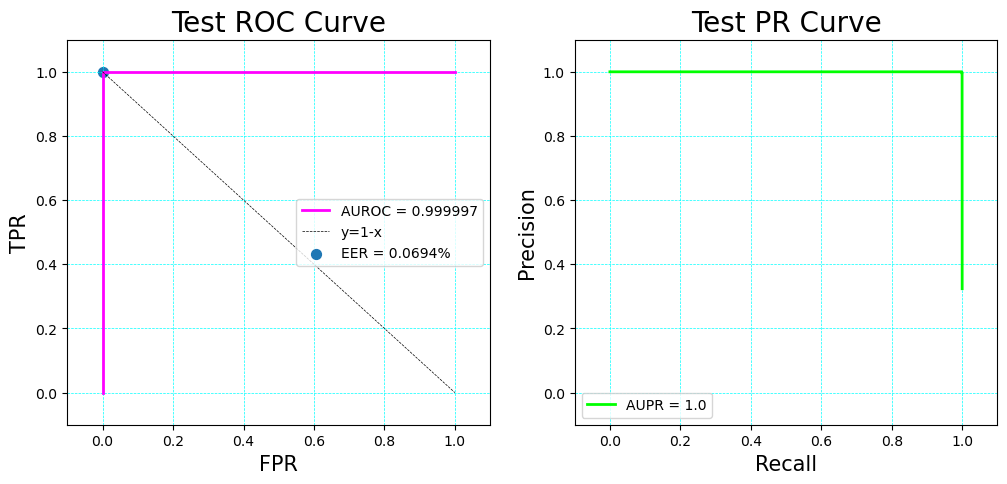

On the Test set:

The AUROC value is:  0.999997
The AUPR value is:  0.999995
The EER is:  0.069444


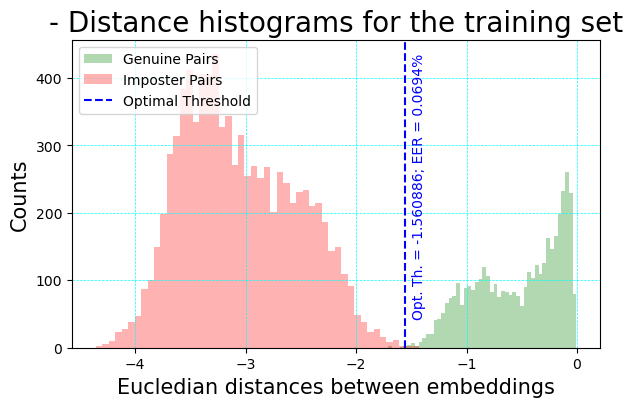

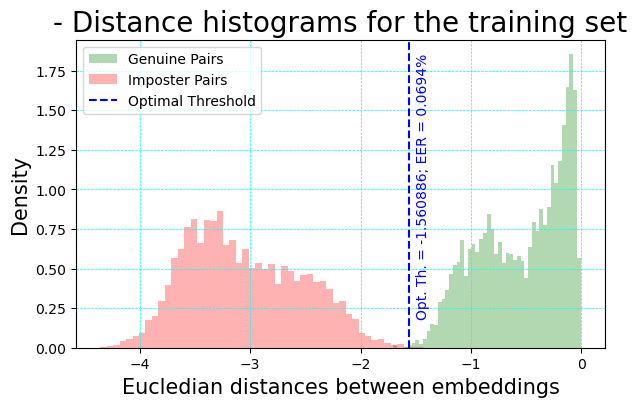

In [38]:

# Result on the Testing Dataset
roc_fpr, roc_tpr, roc_auc, pr_recall, pr_precision, pr_auc, eer_test, optimal_threshold_test = generate_roc_pr_curves(test_dist, labels[0])
plt.figure(figsize=(12,5))
plotting_verification_curves(roc_fpr, roc_tpr, roc_auc, pr_recall, pr_precision, pr_auc, eer_test,"Test")
#plt.savefig("F64_train_ver_plots_AMI.pdf", format="pdf", bbox_inches="tight")
plt.show()
printing_verification_metrics("Test",roc_auc, pr_auc, eer_test, dec_points = 6)

# Displaying the histograms
plt.figure(figsize=(15,4));
plt.subplot(1,2,1); plotting_histograms(-test_dist,labels[0],optimal_threshold_test,eer_test,"- Distance histograms for the training set",num_bins=50,my_alpha=0.3,density=False);
# plt.subplot(1,2,2); plotting_histograms(-val_dist,val_labels,optimal_threshold_val,eer_val,"- Distance histograms for the validation set",num_bins=50,my_alpha=0.3,density=False);
plt.show()

plt.figure(figsize=(15,4));
plt.subplot(1,2,1); plotting_histograms(-test_dist,labels[0],optimal_threshold_test,eer_test,"- Distance histograms for the training set",num_bins=50,my_alpha=0.3,density=True);
# plt.subplot(1,2,2); plotting_histograms(-val_dist,val_labels,optimal_threshold_val,eer_val,"- Distance histograms for the validation set",num_bins=50,my_alpha=0.3,density=True);
#plt.savefig("F64_hists_train_val_AMI.pdf", format="pdf", bbox_inches="tight")
plt.show()







# # Result on the Testing Dataset
# roc_fpr, roc_tpr, roc_auc, pr_recall, pr_precision, pr_auc, eer, optimal_threshold_test = generate_roc_pr_curves(test_dist, test_labels)
# plt.figure(figsize=(12,5))
# plotting_verification_curves(roc_fpr,roc_tpr,pr_recall,pr_precision,"Test")
# plt.show()
# printing_verification_metrics("Test", dec_points = 4)

# # Displaying the histograms
# plt.figure(figsize=(8,5));
# plotting_histograms(-test_dist,test_labels,optimal_threshold_test,"- Distance histograms for the testing set",num_bins=50,my_alpha=0.3,density=False);
# plt.show()

# plt.figure(figsize=(8,5));
# plotting_histograms(-test_dist,test_labels,optimal_threshold_test,"Density histograms for the testing set",num_bins=50,my_alpha=0.3,density=True);
# plt.show()